# Stash

## Code-Snippet for the general implementation of the Kernel
```
        #prepared_X = [(entry_z, entry_x) for entry_x, entry_z in product(Z,X)]
        #        for v1, v2 in prepared_X:
        #result = [self.evaluate(self, elem[0], elem[1]) for elem in prepared_X]
#        result = torch.reshape(torch.Tensor(result), (len(Z), len(X)))
#        for i, a in enumerate(X):
#            for j, b in enumerate(Z):
#                self.evaluate(a, b)
                #result[i][j] = self.f(a, b, str(self.var1), str(self.var2), var_values=var_values)
```

## Implementation for the symmetric derivation of the SE Kernel
```
    def exp_riordan_array(self, max_n):
        """
        See http://oeis.org/A176230
        """
        n, k = var('n, k')
        T(n,k) = factorial(2*n)/(factorial(2*k)*factorial(n-k)*2^(n-k))
        result = [int(T(max_n,k)) for k in range(max_n+1)]
        #result.append(int(1))
        return result

    
    def single_term_extract_deriv_dict(self, d_poly, d_var=var('d')):
        deriv_dict = {}
        # See if it's of the form a*x^n
        if (not len(d_poly.operands()) == 0) and ('^' in str(d_poly.operands()[0]) or '^' in str(d_poly.operands()[1])):
            # 1 if the coefficient is in [1], else it must be in [0]
            coeff_index = int('^' in str(d_poly.operands()[0]))
            coeff = None
            if not d_poly.operands()[coeff_index].is_numeric():
                # If it doesn't exist, a trainable parameter with initial value 1 is created
                if not hasattr(self, str(d_poly.operands()[coeff_index])):
                    setattr(self, str(d_poly.operands()[coeff_index]), PyroParam(torch.tensor(float(1.))))
                coeff = getattr(self, str(d_poly.operands()[coeff_index]))
            else:
                coeff = torch.tensor(float(d_poly.operands()[coeff_index]))
            deriv_dict[d_poly] = {'coeff':coeff} 
        # Else it's of the form x^n
        else:
            deriv_dict[d_poly] = {'coeff':torch.tensor(float(1.))}
        return deriv_dict

    
    def prepare_deriv_dict(self, d_poly, d_var = var('d')):
        """
        Returns a dictionary of the form {a*d^2:{'coeff': a}, b*d^3:{'coeff':b}, d^3:{'coeff': 1 } ...}
        This is read in the derivation process to calculate the exact deriv-function
        """
        deriv_dict = {}
        
        # if the derivatives are just numbers
        if type(d_poly) in [sage.rings.real_mpfr.RealLiteral, sage.rings.integer.Integer]:
            return {d^0:{'coeff':torch.tensor(float(d_poly))}}
        if not type(d_poly) == sage.symbolic.expression.Expression:
            assert "Derivative expression is neither sage.symbolic.expression.Expression nor number"
        # Catching the case of derivatives being d^n which causes derivatives.operands() to be the list [d, n] instead of [d^n]
        # The below steps will also recognize exponential expressions of the form n^x
        # this will result in unexpected behaviour or exit with an error
        if ((not all(op.has(d_var) for op in d_poly.operands()) and len(d_poly.operands()) == 2) or (d_poly.has(d_var) and len(d_poly.operands()) == 0)):
            return self.single_term_extract_deriv_dict(d_poly, d_var)
        else:
            # Iterate over all the operands (a*d^3, b*d^2, c*d, ...)
            for operand in d_poly.operands():
                # If the operand does not contain a "d" it is a constant
                if not operand.has(d_var):
                    deriv_dict[d^0] = {'coeff':torch.tensor(float(operand))}
                # If it contains a "d" it is a derivative
                # "append" the new dict to the previous dict
                deriv_dict = {**deriv_dict, **self.single_term_extract_deriv_dict(operand, d_var)}
            return deriv_dict
    
    
    def symmetric_derive(self, derivation_expression):

        """
        Derivation approach for matrix entries where T = T.t() for
        T K T.t()
        (e.g. diagonal entries which are diff'd using the same polynomial twice)
        
        For a particular derivative a*d^n we see the following pattern:
         - We have coefficients from exp_riordan_array(n, i) with the
           additional factor $(-1)^i/l^(2*(n+i))$ for the i-th coefficient
         - We have in total n+1 summands for the derivative
         - We have the $(x1 - x2)^i$ terms in the derivative
        """        
        derivation_term_dict = self.prepare_deriv_dict(derivation_expression)
                        
        def evaluate(X, Z=None):
            self.result_term = lambda self, l_, coefficients, i : coefficients[i]*(int(-1))**(i%int(2))*l_**(i+int(1))*self.K_1**i
            
            self._square_scaled_dist(X, Z)
            self.K_4 = torch.mul(self.var, torch.exp(float(-0.5) * self.K_1*(float(1)/self.length**float(2))))
            result = None
            for term in derivation_term_dict:
                max_exponent = int(term.degree(var('d')))
                coefficients = self.exp_riordan_array(max_exponent)
                l_ = float(1)/self.length^(float(2)*torch.tensor(max_exponent))
                if result is None:
                    temp = [self.result_term(self, l_, coefficients, i) for i in range(max_exponent+1)]
                    result = sum(temp)*derivation_term_dict[term]['coeff']
                else:
                    result += sum([self.result_term(self, l_, coefficients, i) for i in range(max_exponent)])*derivation_term_dict[term]['coeff']
            return self.K_4*result

        return evaluate
            
        
    def derive(self, derivation_expression):
        """
        Assumptions:
        The derivation string has the form ax^n+bx^m+... 
        with a, b real numbers and m,n positive integers.
        """
        self.K_4 + self.K_1.matmul(self.K_4)
        return
```

# Helper classes

def reconstruct(operands, additional_variables=None):
    """
    For each token
    {
        If (token is a number)
        {
            Push value onto stack
        }

        If (token is an operator)
        {
            Pop 2 top values from the stack
            Evaluate operator using popped values as args
            Push result onto stack
        }
    }
    """
    variables = ['pi', 'e', 'exp']
    if not additional_variables is None:
        variables.extend(additional_variables)
    stack = []
    
    def f(x1, x2=None, x1_var = 'x1', x2_var = 'x2', var_values=None):
        if x2 is None:
            x2 = x1
            x2_var = x1_var
        for token in operands:
            #pdb.set_trace()
            if bool(re.match(r'-?\d+\.?\d*', token)) or token in variables:
                stack.append(token)
            elif is_op(token):
                op = find_op(token)
                if op.ops == 2:
                    v1 = stack.pop()
                    v2 = stack.pop()
                    
                    if type(v1) is torch.Tensor:
                        pass
                    elif v1 == x1_var:
                        v1 = torch.tensor(float(x1))
                    elif v1 == x2_var:
                        v1 = torch.tensor(float(x2))
                    elif v1 in var_values.keys():
                        v1 = var_values[v1]
                        #torch.tensor(float(var_values[v1]))
                    elif bool(re.match(r'-?\d+\.?\d*', v1)):
                        v1 = torch.tensor(float(v1))
                        
                    if type(v2) is torch.Tensor:
                        pass    
                    elif v2 == x1_var:
                        v2 = torch.tensor(float(x1))
                    elif v2 == x2_var:
                        v2 = torch.tensor(float(x2))
                    elif v2 in var_values.keys():
                        v2 = var_values[v2]
                        #torch.tensor(float(var_values[v2]))
                    elif bool(re.match(r'-?\d+\.?\d*', v2)):
                        v2 = torch.tensor(float(v2))
                    if v2 == 'e' and op.sym == '^':
                        result = torch.exp(v1)
                        
                    else:
                        result = op.top(v2, v1)
                        
                    stack.append(result)
                elif op.ops == 1:
                    v1 = stack.pop()
                    if type(v1) is torch.Tensor:
                        pass
                    elif v1 == x1_var:
                        v1 = torch.tensor(float(x1))
                    elif v1 == x2_var:
                        v1 = torch.tensor(float(x2))
                    elif v1 in var_values.keys():
                        v1 = var_values[v1]
                        #torch.tensor(float(var_values[v1]))
                    elif bool(re.match(r'-?\d+\.?\d*', v1)):
                        v1 = torch.tensor(float(v1))

                    result = op.top(v1)
                    stack.append(result)        
        return result
    return f

# Goal

Calculate the derivatives given a matrix $T$, containing the instructions for the derivatives, and $M$, the matrix-to-be-derived.

# Plan

## Scenario 1: Performing the matrix multiplication first

In this case I have to split the function into the summands and derive each summand according to $T$.

**Issues:**
 - Split the expression into each summand and reconstruct them
 - 
 
## Scenario 2: Perform differentiation simultaneously with matrix multiplication

In this case I simulate the matrix multiplication and use the information of the rows in $T$ to derive the entries of $M$.
For this I will have to splot the entry of $T$ and peform each entry on the complete entry of $M$.
-> If I can do this I can also do Scenario 1

In [1]:
import pdb
import numpy as np
import sage
import ast

In [2]:
# On having a variable number of values for derivatives
# https://ask.sagemath.org/question/52075/differentiating-function-with-fluctuating-number-of-variables/


# Running simple tests

## Simple (single) differential equation

**Function:**    
$f' = g$    
$f(t) = \sin(t)$

Which covariance function do I use?    
$k(t_1, t_2) = \text{SE_kernel}(t_1, t_2)$

How does the GP look like then?    
I should have the GP $G \sim \mathcal{GP}
(\mathbf{0}, d_{t_1} k(t_1, t_2) d_{t_2})$, right?    
So I have to derive the function twice, once in the direction of $t_1$ and once in the direction of $t_2$.

## Simple differential equation (2nd deriv)

The same as above, but now we have the following function:    
$f'' = g$    
$f(t) = \sin(t)$    

This will then cause the GP to look as follows:    
$G \sim \mathcal{GP}
(\mathbf{0}, d_{t_1}^2 k(t_1, t_2) d_{t_2}^2)$

In [3]:
#import sys
#!{sys.executable} -m pip install torch==1.8.1 line_profiler --no-cache-dir

In [4]:
%load_ext line_profiler

In [5]:
#import sys
#!{sys.executable} -m pip install pyro-ppl --no-cache-dir

In [6]:
import os
import matplotlib.pyplot as plt
import torch
# To ensure that it takes the local pyro copy, add it to the PATH
import sys
sys.path.insert(0, 'pyro')

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from inspect import getmembers, isfunction

In [7]:
torch.autograd.set_detect_anomaly(True)

# Kernels

In [8]:
ONE_DIM = False

In [9]:
smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

In [10]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=int(0),
         model=None, kernel=None, n_test=int(500)):
    #pdb.set_trace()
    plt.figure(figsize=(int(12), int(6)))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(float(-0.5), float(5.5), n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - float(2.0) * sd).numpy(),
                         (mean + float(2.0) * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(float(-0.5), float(5.5), n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=int(2), alpha=float(0.4))

    plt.xlim(float(-0.5), float(5.5))

In [11]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def mult_dim_plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=int(0),
         model=None, kernel=None, n_test=int(500)):
    #plt.figure(figsize=(int(24), int(12)))
    if y.ndim == 1:
        assert "This seems to be one dimensional, use the `plot` function instead"
    else:
        # Initialise the subplot function using number of rows and columns
        figure, axis = plt.subplots(1, y.ndim)
    if plot_observed_data:
            for dim in range(y.ndim):
                axis[dim].plot(X.numpy(), y[dim].numpy(), 'kx')
    
    if plot_predictions:
        Xtest = torch.linspace(float(-0.5), float(5.5), n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
                #mean = [torch.index_select(mean, int(0), torch.as_tensor([i for i in range(n_test*y.ndim) if i%y.ndim == k])) for k in range(y.ndim)]
                mean = [torch.index_select(mean, int(0), torch.as_tensor([i for i in range(n_test*k, n_test*(k+1))])) for k in range(y.ndim)]
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        sd = [torch.index_select(sd, int(0), torch.as_tensor([i for i in range(n_test*k, n_test*(k+1))])) for k in range(y.ndim)]
        for dim in range(y.ndim):
            axis[dim].plot(Xtest.numpy(), mean[dim].numpy(), 'r', lw=int(2))
            axis[dim].fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                 (mean[dim] - float(2.0) * sd[dim]).numpy(),
                 (mean[dim] + float(2.0) * sd[dim]).numpy(),
                 color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(float(-0.5), float(5.5), n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test*y.ndim).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test*y.ndim), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        temp_samples = [torch.index_select(samples[0], int(0), torch.as_tensor([i for i in range(n_test*k, n_test*(k+1))])) for k in range(y.ndim)]

        
        for dim in range(y.ndim):
            axis[dim].plot(Xtest.numpy(), temp_samples[dim], lw=int(2), alpha=float(0.4))

    plt.xlim(float(-0.5), float(5.5))
    plt.show

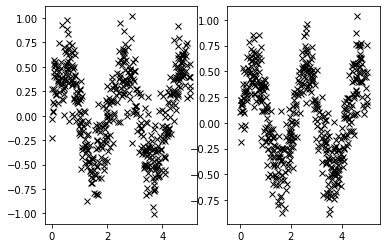

In [12]:
N = 500
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
if ONE_DIM:
    # One dimensional case
    y = float(0.5) * torch.sin(int(3)*X) + dist.Normal(float(0.0), float(0.2)).sample(sample_shape=(N,))
    plot(plot_observed_data=True)  # let's plot the observed data
else:
    # 2D outputs
    y = float(0.5) * torch.sin(int(3)*torch.stack([X, X])) + dist.Normal(float(0.0), float(0.2)).sample(sample_shape=(2,N))
    mult_dim_plot(plot_observed_data=True)  # let's plot the observed data



In [13]:
type(X)

<class 'torch.Tensor'>

# Creating a Kernel

In [14]:
"""
a, d = var('a, d')
dx1, dx2 = var('dx1, dx2')

left_poly = dx1^2 + dx1 + dx1^2 + dx1^10
right_poly = dx2 + dx2^2 + dx2^10
kernel3 = kernel.asymmetric_deriv(left_poly, right_poly)(X, Z=Z)"""

"\na, d = var('a, d')\ndx1, dx2 = var('dx1, dx2')\n\nleft_poly = dx1^2 + dx1 + dx1^2 + dx1^10\nright_poly = dx2 + dx2^2 + dx2^10\nkernel3 = kernel.asymmetric_deriv(left_poly, right_poly)(X, Z=Z)"

In [15]:
from kernels import *

In [16]:
#sigma, l = var('sigma, l')
#kernel = SageExpression(1, sigma^2*exp(-1*(x1-x2)^2/(2*l^2)), hyperparameters={'sigma':0.1, 'l':1})

#kernel = gp.kernels.RBF(input_dim=int(1), variance=torch.tensor(float(0.1)),
#                        lengthscale=torch.tensor(float(1.)))

kernel = TestKernel(input_dim=int(1))
kernel2 = TestKernel(input_dim=int(1), var=float(0.1), length=int(1))
if ONE_DIM:
    kernel3 = MatrixKernel(int(1), [kernel])
else:
    kernel3 = MatrixKernel(int(1), [kernel, kernel2])
gpr = gp.models.GPRegression(X, y, kernel3, noise=torch.tensor(float(1.)))
#gpr = torch.jit.script(gp.models.GPRegression(X, y, kernel3, noise=torch.tensor(float(1.))))

In [17]:
dx1, dx2, a, b = var('dx1', 'dx2', 'a', 'b')
left = a*dx1
right = b*dx2
kernel.asymmetric_deriv(left_poly=left, right_poly=right)
for p in kernel.named_parameters():
    print(p)

('var_unconstrained', Parameter containing:
tensor(0., requires_grad=True))
('length_unconstrained', Parameter containing:
tensor(0., requires_grad=True))


In [18]:
import timeit
Z = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
#print(timeit.timeit(lambda: kernel2.forward(X,Z=Z), number=int(1)))


In [19]:
#print(all(entry < float(0.00001) for entry in (kernel3.forward(X, Z=X)-torch.transpose(kernel3.forward(X, Z=X), int(0), int(1))).flatten()))
#print(torch.transpose(kernel3.forward(X, Z=X), int(0), int(1))[:4,:4])
#print(kernel3.forward(X, Z=X)[:4,:4])
#torch.eig(kernel3.forward(X, Z=X))[0]

In [20]:
#%lprun -f kernel3.matrix[0].forward kernel3.matrix[0].forward(X, Z=Z)
#%lprun -f kernel42.forward kernel42.forward(X, Z=Z)
#kernel3.forward(X, Z = Z)
#%lprun -f kernel3.forward kernel3.forward(X, Z = Z)

#%time kernel.forward(X, Z = Z)

In [21]:
#result1 = kernel.forward(X, Z = Z)
#result2 = kernel2.forward(X,Z=Z)
#result3 = kernel3.forward(X,Z=Z)

#%time kernel2.forward(X, Z = Z)


In [22]:
for gppm in gpr.named_pyro_params():
    print(gppm)

('noise', tensor(1., grad_fn=<AddBackward0>))
('kernel.kernel_0.var', tensor(1., grad_fn=<AddBackward0>))
('kernel.kernel_0.length', tensor(1., grad_fn=<AddBackward0>))
('kernel.kernel_1.var', tensor(0.1000, grad_fn=<AddBackward0>))
('kernel.kernel_1.length', tensor(1., grad_fn=<AddBackward0>))


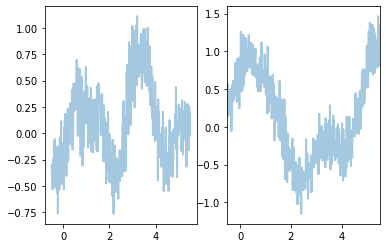

In [31]:
if ONE_DIM:
    plot(model=gpr, kernel=kernel3, n_prior_samples=int(2))
else:
    mult_dim_plot(model=gpr, kernel=kernel3, n_prior_samples=int(1))

In [24]:
#%%prun
optimizer = torch.optim.Adam(gpr.parameters(), lr=float(0.05))
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
# TODO Torch newton optimizer?
# Trust-region, SQP, BFGS, LBFGS recherchieren!
# TODO Hyperparameter während Training plotten

losses = []
num_steps = 100 if not smoke_test else 2
import time
time_list = list()
hyper_iteration_list = list()
for j in range(1):
    hyperparam_dict = {param[0]:list() for param in gpr.named_parameters()}
    timestamp1 = time.time()
    for i in range(num_steps):
        #hyperparam_list.append(gpr.named_pyro_params())
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        for param in gpr.named_parameters():
            hyperparam_dict[param[0]].append(float(param[1]))
    timestamp2 = time.time()
    time_list.append(timestamp2 - timestamp1)
    hyper_iteration_list.append(hyperparam_dict)
    print("This took %.2f seconds"% (timestamp2 - timestamp1))
print(f"avg_time = {np.mean(time_list)}")


This took 20.44 seconds
avg_time = 20.437963247299194


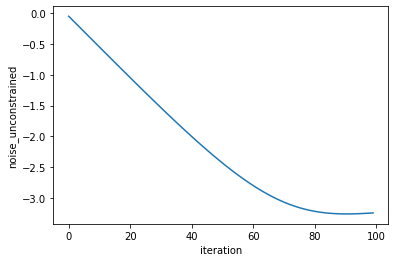

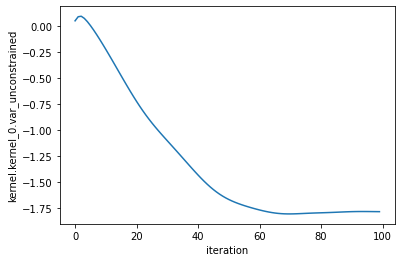

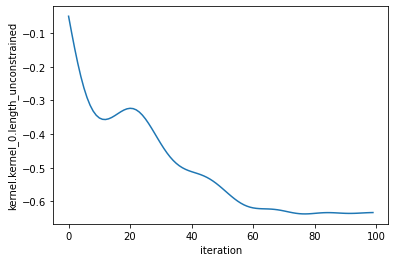

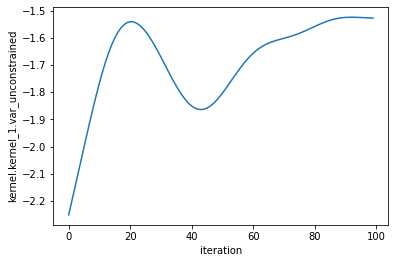

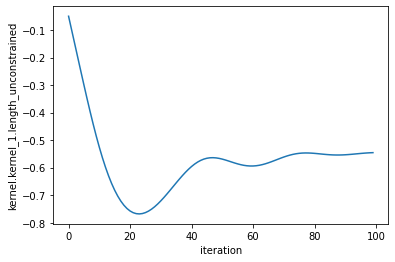

In [25]:
for i in range(len(hyper_iteration_list)):
    for key in hyper_iteration_list[i]:
        plt.plot([k for k in range(len(hyper_iteration_list[i][key]))], hyper_iteration_list[i][key], label="Hyperparam")
        plt.xlabel(f"iteration")
        plt.ylabel(f"{key}")
        plt.show()

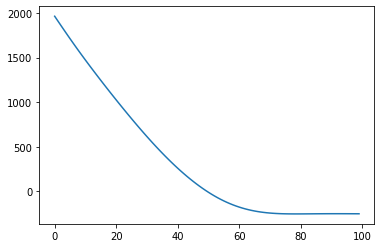

In [26]:
# let's plot the loss curve after 2500 steps of training
plt.plot(losses)

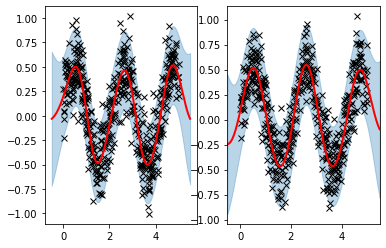

In [27]:
if ONE_DIM:
    plot(model=gpr, plot_observed_data=True, plot_predictions=True)
else:
    mult_dim_plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [28]:
"""
Fehlersuche:
 - Matrix[0] trainiert die Hyperparameter wahrscheinlich nicht
 - TODO check if noise_unconstrained & other hyperparams are log(noise)
 - Wahrscheinlich y falsch zusammengebaut
 - Cov. Matr. ist kaputt (Negative Eigenwerte)
 - Erwartung Diagonale: Cov. Matr = var**2
 
 
Mögliche Überprüfungen (Unit Tests):
 - Eigenwerte alle positiv (oder sehr sehr klein negativ)
 - && Eigenwerte dürfen keinen Imaginärteil haben (oder sehr sehr klein)
 - M - M.t() == 0 ?
 - Diagonalelemente immer größer als restlichen Werte auf der Horizontalen/Vertikalen Achse
"""


#print(kernel3.var)
#print(kernel3.length)

'\nFehlersuche:\n - Matrix[0] trainiert die Hyperparameter wahrscheinlich nicht\n - TODO check if noise_unconstrained & other hyperparams are log(noise)\n - Wahrscheinlich y falsch zusammengebaut\n - Cov. Matr. ist kaputt (Negative Eigenwerte)\n - Erwartung Diagonale: Cov. Matr = var**2\n \n \nMögliche Überprüfungen (Unit Tests):\n - Eigenwerte alle positiv (oder sehr sehr klein negativ)\n - && Eigenwerte dürfen keinen Imaginärteil haben (oder sehr sehr klein)\n - M - M.t() == 0 ?\n - Diagonalelemente immer größer als restlichen Werte auf der Horizontalen/Vertikalen Achse\n'

In [29]:
for gppm in gpr.named_pyro_params():
    print(gppm)

('noise', tensor(0.0390, grad_fn=<AddBackward0>))
('kernel.kernel_0.var', tensor(0.1682, grad_fn=<AddBackward0>))
('kernel.kernel_0.length', tensor(0.5309, grad_fn=<AddBackward0>))
('kernel.kernel_1.var', tensor(0.2175, grad_fn=<AddBackward0>))
('kernel.kernel_1.length', tensor(0.5796, grad_fn=<AddBackward0>))


# Running more complex tests

## Simple system of differential equations
**Function:**    


In [30]:
0.7^(2000/50)*10000

0.00636680576090901